# Image recognition

In [3]:
import torch
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large", torch_dtype=torch.float16).to("cuda")

img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

# conditional image captioning
text = "a picture of "
inputs = processor(raw_image, text, return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs)
prompt = processor.decode(out[0], skip_special_tokens=True)
prompt

/home/jupyter-chasewes/.local/lib/python3.9/site-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'a picture of a woman sitting on the beach with a dog'

In [4]:
resized_image = raw_image.resize((1024,1024))

In [6]:
# !pip install opencv-python transformers accelerate
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel, AutoencoderKL
from diffusers.utils import load_image
import numpy as np
import torch

import cv2
from PIL import Image

# download an image
image = load_image(
    "https://hf.co/datasets/hf-internal-testing/diffusers-images/resolve/main/sd_controlnet/hf-logo.png"
)
# image = resized_image

# initialize the models and pipeline
controlnet_conditioning_scale = 0.5  # recommended for good generalization
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-canny-sdxl-1.0", torch_dtype=torch.float16
)
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", controlnet=controlnet, vae=vae, torch_dtype=torch.float16
)
pipe.enable_model_cpu_offload()



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
image.size

(1024, 1024)

In [8]:
prompt

'a picture of a woman sitting on the beach with a dog'

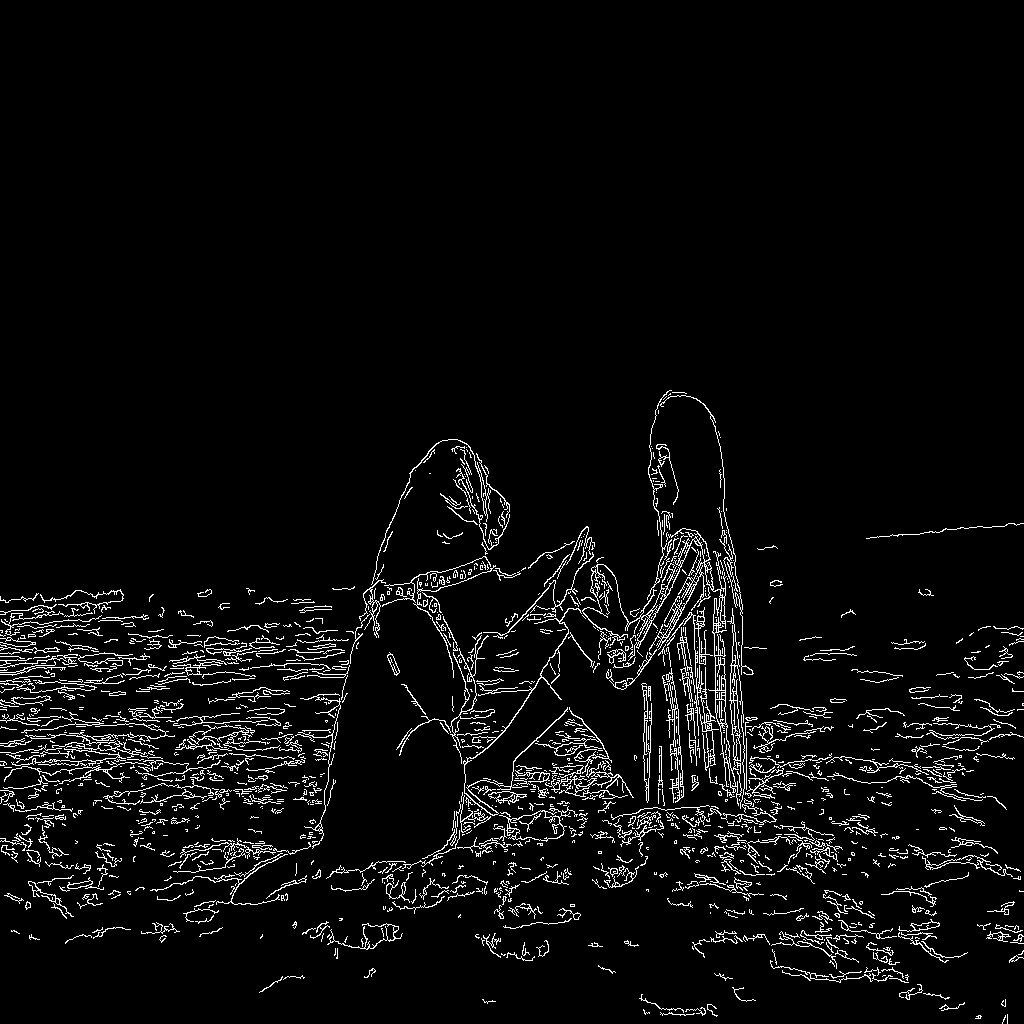

In [9]:
# get canny image

image = resized_image

image = np.array(image)
image = cv2.Canny(image, 100, 200)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

canny_image

  0%|          | 0/50 [00:00<?, ?it/s]

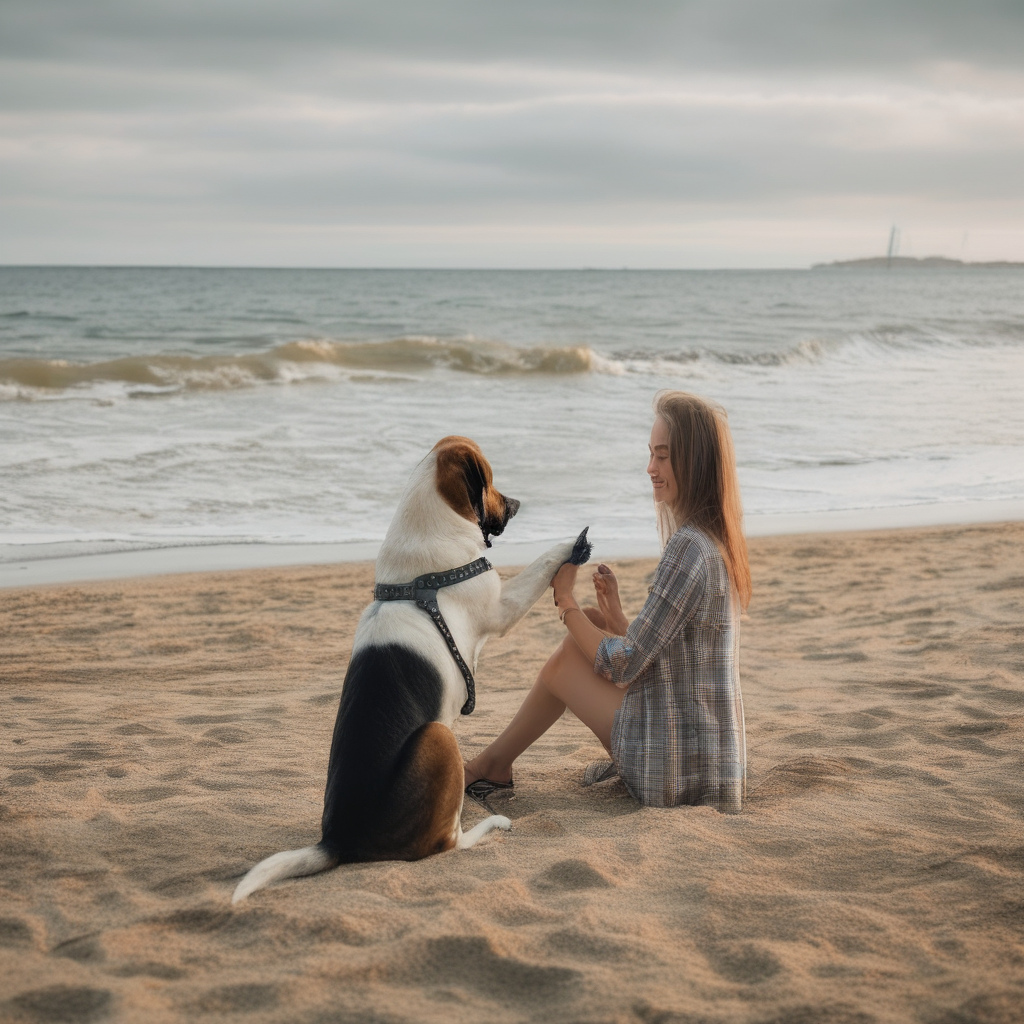

In [10]:
# generate image
image = pipe(
    prompt, controlnet_conditioning_scale=.5, image=canny_image
).images[0]
image

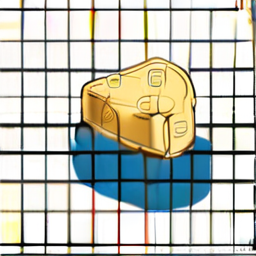

In [13]:
# generate image
image = pipe(
    " ", controlnet_conditioning_scale=controlnet_conditioning_scale, image=canny_image
).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]